# DQAN (Deep Q-Adverserial Nets): DQN (Deep Q-Nets) + GAN (Gen. Adv. Nets)

In this notebook, we'll combine a DQN (deep Q-net) with GAN (generative adverserial net) that can learn to play games through reinforcement learning without any reward function. We'll call this network DQAN (deep Q adverserial net). 
Adverserial nets learn to maximize the current reward based the past rewards.
Q-net learns to maximize the future rewards based on the current reward.
Given a task and known when the task is done or failed, we should be able to learn the task.

# DQN
More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import gym
import tensorflow as tf
import numpy as np

>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

In [2]:
# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.reset()
rewards, states, actions, dones = [], [], [], []
for _ in range(10):
    # env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    states.append(state)
    rewards.append(reward)
    actions.append(action)
    dones.append(done)
    print('state, action, reward, done, info')
    print(state, action, reward, done, info)
    if done:
        print('state, action, reward, done, info')
        print(state, action, reward, done, info)
        states.append(state)
        rewards.append(reward)
        actions.append(action)
        dones.append(done)

state, action, reward, done, info
[ 0.03623621 -0.22958492 -0.00155073  0.33378668] 0 1.0 False {}
state, action, reward, done, info
[ 0.03164452 -0.03444093  0.00512501  0.04061513] 1 1.0 False {}
state, action, reward, done, info
[ 0.0309557   0.16060716  0.00593731 -0.25044641] 1 1.0 False {}
state, action, reward, done, info
[ 0.03416784 -0.03459908  0.00092838  0.04410334] 0 1.0 False {}
state, action, reward, done, info
[ 0.03347586  0.16050955  0.00181045 -0.24828653] 1 1.0 False {}
state, action, reward, done, info
[ 0.03668605  0.3556056  -0.00315528 -0.54039785] 1 1.0 False {}
state, action, reward, done, info
[ 0.04379816  0.55077176 -0.01396324 -0.83407329] 1 1.0 False {}
state, action, reward, done, info
[ 0.0548136   0.74608167 -0.0306447  -1.13111466] 1 1.0 False {}
state, action, reward, done, info
[ 0.06973523  0.94159117 -0.053267   -1.43324934] 1 1.0 False {}
state, action, reward, done, info
[ 0.08856705  1.1373283  -0.08193198 -1.74209169] 1 1.0 False {}


To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [4]:
print(rewards[-20:])
print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print(np.max(np.array(actions)), np.min(np.array(actions)))
print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print(np.max(np.array(rewards)), np.min(np.array(rewards)))
print(np.max(np.array(states)), np.min(np.array(states)))

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
(10,) (10, 4) (10,) (10,)
float64 float64 int64 bool
1 0
2
1.0 1.0
1.1373282982386719 -1.7420916926362668


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [5]:
def model_input(state_size):
    # Given data
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    next_states = tf.placeholder(tf.float32, [None, state_size], name='next_states')
    
    # Actions as output
    actions = tf.placeholder(tf.int32, [None], name='actions')

    # Target Q values for training
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    return states, next_states, actions, targetQs

In [6]:
# tf.layers.dense(
#     inputs, ????????????????????????
#     units, ??????????????????????
#     activation=None,
#     use_bias=True, OOOOOOOOOOOOOOOOOOOOOOOK
#     kernel_initializer=None,
#     bias_initializer=tf.zeros_initializer(), OOOOOOOOOOOOOOOK
#     kernel_regularizer=None,
#     bias_regularizer=None,
#     activity_regularizer=None,
#     kernel_constraint=None,
#     bias_constraint=None,
#     trainable=True, ??????????????????
#     name=None,
#     reuse=None
# )

In [20]:
# Q function
def generator(states, state_size, action_size, hidden_size, reuse=False, alpha=0.1): #training=True ~ batchnorm
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        #bn1 = tf.layers.batch_normalization(h1, training=training) #training=True ~ batchnorm
        nl1 = tf.maximum(alpha * h1, h1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        #bn2 = tf.layers.batch_normalization(h2, training=training) #training=True ~ batchnorm
        nl2 = tf.maximum(alpha * h2, h2)
        
        # # Output layer
        # logits_actions = tf.layers.dense(inputs=nl2, units=action_size, trainable=False)        
        # #predictions = tf.nn.softmax(logits_actions)

        # # Output layer
        # logits_next_states = tf.layers.dense(inputs=nl2, units=state_size, trainable=False)        
        # #predictions = tf.nn.softmax(logits_next_states)

        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=(state_size + action_size))
        
        # Split the states and actions (opposite of fusion)
        logits_next_states, logits_actions = tf.split(value=logits, axis=1, num_or_size_splits=[state_size, action_size])

        return logits_actions, logits_next_states

In [21]:
# This is a reward function: Rt(St+1, at) or Rt(~St+1, ~at)
def discriminator(next_states, actions, hidden_size, reuse=False, alpha=0.1): #training=True ~ batchnorm
    with tf.variable_scope('discriminator', reuse=reuse):
        # Stack/concatenate/fuse actions and states or 
        # predicted/reconstructed actions and states
        x_fused = tf.concat(values=(next_states, actions), axis=1)
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        #bn1 = tf.layers.batch_normalization(h1, training=True)
        nl1 = tf.maximum(alpha * h1, h1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        #bn2 = tf.layers.batch_normalization(h2, training=True)
        nl2 = tf.maximum(alpha * h2, h2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)   
        #predictions = tf.sigmoid(logits)

        # logits for loss and reward/prob/out
        return logits

In [22]:
# Qt(St, At) = Rt(St+1, At) + max(alpha*Qt+1(St+1))
def model_loss(states, next_states, state_size, actions, action_size, hidden_size, targetQs, alpha=0.1):
    """
    Get the loss for the discriminator and generator
    :param states: real current input states or observations given
    :param actions: real actions given
    :return: A tuple of (discriminator loss, generator loss)
    """
    # The fake/generated actions
    actions_logits, next_states_logits = generator(states=states, state_size=state_size, hidden_size=hidden_size, 
                                              action_size=action_size)
    #print(actions_logits.shape, next_states_logits.shape)
    actions_fake = tf.nn.softmax(actions_logits)
    next_states_fake = tf.sigmoid(x=next_states_logits)
    d_logits_fake = discriminator(next_states=next_states_fake, actions=actions_fake, hidden_size=hidden_size, reuse=False)

    # The real onehot encoded actions
    actions_real = tf.one_hot(actions, action_size)
    next_states_real = tf.sigmoid(x=next_states) 
    d_logits_real = discriminator(next_states=next_states_real, actions=actions_real, hidden_size=hidden_size, reuse=True)

    # Training the rewarding function
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    # Train the generate to maximize the current reward 0-1
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))

    # Train the generator to maximize the future rewards: Bellman equations: loss (targetQ - Q)^2
    Qs = tf.reduce_sum(tf.multiply(actions_logits, actions_real), axis=1)
    q_loss = tf.reduce_mean(tf.square(targetQs - Qs))

    # The generated rewards for Bellman equation
    rewards_fake = tf.sigmoid(d_logits_fake)
    rewards_real = tf.sigmoid(d_logits_real)

    return d_loss, g_loss, q_loss, actions_logits, Qs, rewards_fake, rewards_real

In [23]:
def model_opt(d_loss, g_loss, q_loss, learning_rate):
    """
    Get optimization operations
    :param d_loss: Discriminator/Reward loss Tensor for reward function
    :param g_loss: Generator/Q-value loss Tensor for action & next state predicton
    :param q_loss: Value loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
        q_opt = tf.train.AdamOptimizer(learning_rate).minimize(q_loss, var_list=g_vars)

    return d_opt, g_opt, q_opt

In [24]:
class DQAN:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.next_states, self.actions, self.targetQs = model_input(state_size=state_size)
        #print(self.states, self.next_states, self.actions, self.targetQs)

        # Create the Model: calculating the loss and forwad pass
        self.d_loss, self.g_loss, self.q_loss, self.actions_logits, self.Qs, self.rewards_fake, self.rewards_real = model_loss(
            state_size=state_size, action_size=action_size, actions=self.actions, 
            states=self.states, next_states=self.next_states, 
            hidden_size=hidden_size, targetQs=self.targetQs)

        # Update the model: backward pass and backprop
        self.d_opt, self.g_opt, self.q_opt = model_opt(d_loss=self.d_loss, g_loss=self.g_loss, 
                                                       q_loss=self.q_loss, learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [25]:
from collections import deque

class Memory():    
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [26]:
train_episodes = 2000          # max number of episodes to learn from
max_steps = 200               # max steps in an episode
gamma = 0.99                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
hidden_size = 64              # number of units in each Q-network hidden layer -- simulation
state_size = 4                # number of units for the input state/observation -- simulation
action_size = 2               # number of units for the output actions -- simulation

# Memory parameters
memory_size = 10000            # memory capacity
batch_size = 10                # experience mini-batch size
learning_rate = 0.001          # learning rate for adam

In [27]:
tf.reset_default_graph()
model = DQAN(action_size=action_size, hidden_size=hidden_size, state_size=state_size, 
                 learning_rate=learning_rate)

## Populate the experience memory

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [28]:
# Initialize the simulation
env.reset()

# Take one random step to get the pole and cart moving
state, reward, done, _ = env.step(env.action_space.sample())

# init memory
memory = Memory(max_size=memory_size)

# Make a bunch of random actions and store the experiences
for _ in range(batch_size):
    # Uncomment the line below to watch the simulation
    # env.render()

    # Make a random action
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)

    if done:
        # The simulation fails so no next state
        next_state = np.zeros(state.shape)
        
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        
        # Start new episode
        env.reset()
        
        # Take one random step to get the pole and cart moving
        state, reward, done, _ = env.step(env.action_space.sample())
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        state = next_state

## Training

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [ ]:
# Now train with experiences
saver = tf.train.Saver()

# Total rewards and losses list for plotting
rewards_list = []
d_loss_list, g_loss_list, q_loss_list = [], [], [] 
rewards_fake_list = []

# TF session for training
with tf.Session() as sess:
    
    # Initialize variables
    sess.run(tf.global_variables_initializer())

    # Training episodes/epochs
    step = 0
    for ep in range(train_episodes):
        
        # Env/agent steps/batches/minibatches
        total_reward = 0
        d_loss, g_loss, q_loss = 0, 0, 0
        rewards_fake_mean = 0
        t = 0
        while t < max_steps:
            step += 1
            
            # Uncomment this next line to watch the training
            # env.render() 
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from model
                feed_dict = {model.states: state.reshape((1, *state.shape))}
                actions_logits = sess.run(model.actions_logits, feed_dict)
                action = np.argmax(actions_logits)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
    
            # Cumulative reward
            total_reward += reward
            
            # Episode/epoch training is done/failed!
            if done:
                # the episode ends so no next state
                next_state = np.zeros(state.shape)
                t = max_steps
                
                print('-------------------------------------------------------------------------------')
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Average reward fake: {}'.format(rewards_fake_mean),
                      'Training d_loss: {:.4f}'.format(d_loss),
                      'Training g_loss: {:.4f}'.format(g_loss),
                      'Training q_loss: {:.4f}'.format(q_loss),
                      'Explore P: {:.4f}'.format(explore_p))
                print('-------------------------------------------------------------------------------')
                
                # total rewards and losses for plotting
                rewards_list.append((ep, total_reward))
                rewards_fake_list.append((ep, rewards_fake_mean))
                d_loss_list.append((ep, d_loss))
                g_loss_list.append((ep, g_loss))
                q_loss_list.append((ep, q_loss))
                
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                
                # Start new episode
                env.reset()
                
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            #rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            
            # Train the model
            # feed_dict={model.states: next_states}
            # next_actions_logits, next_rewards_fake = sess.run([model.actions_logits, model.rewards_fake], feed_dict)
            feed_dict = {model.states: states}
            rewards_fake = sess.run(model.rewards_fake, feed_dict)
            feed_dict={model.states: next_states}
            next_actions_logits = sess.run(model.actions_logits, feed_dict)

            # Mean/average fake rewards or rewarded generated actions
            rewards_fake_mean = np.mean(rewards_fake.reshape(-1))
            
            # Set target_Qs to 0 for states where episode ends
            episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
            next_actions_logits[episode_ends] = (0, 0)

            # Bellman equation: Qt = Rt + max(Qt+1)
            targetQs = rewards_fake.reshape(-1) + (gamma * np.max(next_actions_logits, axis=1))
            # print('DEBUGGING', targetQs.shape, next_rewards_fake.shape, next_actions_logits.shape, np.max(next_actions_logits, axis=1).shape)

            # Updating the model
            # print(states.shape, next_states.shape, targetQs.shape, actions.shape)
            feed_dict = {model.states: states, model.next_states: next_states, model.actions: actions, model.targetQs: targetQs}
            #states, next_states, actions, Qs = sess.run([model.states, model.next_states, model.actions, model.Qs], feed_dict)
            #print(states.shape, next_states.shape, actions.shape, Qs.shape)
            #rewards_real = sess.run(model.rewards_real, feed_dict)
            #d_loss = sess.run(model.d_loss, feed_dict)
            d_loss, _ = sess.run([model.d_loss, model.d_opt], feed_dict)
            g_loss, _ = sess.run([model.g_loss, model.g_opt], feed_dict)
            q_loss, _ = sess.run([model.q_loss, model.q_opt], feed_dict)
            
    # Save the trained model 
    saver.save(sess, 'checkpoints/DQAN-cartpole.ckpt')

-------------------------------------------------------------------------------
Episode: 0 Total reward: 4.0 Average reward fake: 0.49600401520729065 Training d_loss: 1.3503 Training g_loss: 0.7040 Training q_loss: 0.3883 Explore P: 0.9996
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1 Total reward: 12.0 Average reward fake: 0.4843626022338867 Training d_loss: 1.3258 Training g_loss: 0.7298 Training q_loss: 1.3079 Explore P: 0.9984
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2 Total reward: 15.0 Average reward fake: 0.46419015526771545 Training d_loss: 1.2461 Training g_loss: 0.7714 Training q_loss: 1.0862 Explore P: 0.9969
-------------------------------------------------------------------------------
---------------------------------------

-------------------------------------------------------------------------------
Episode: 26 Total reward: 17.0 Average reward fake: 0.0027573187835514545 Training d_loss: 0.0070 Training g_loss: 5.9505 Training q_loss: 2274.9844 Explore P: 0.9568
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 27 Total reward: 23.0 Average reward fake: 0.0025882641784846783 Training d_loss: 0.0061 Training g_loss: 5.9782 Training q_loss: 74.7151 Explore P: 0.9546
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 28 Total reward: 29.0 Average reward fake: 0.0019287423929199576 Training d_loss: 0.0043 Training g_loss: 6.2663 Training q_loss: 752.1080 Explore P: 0.9519
-------------------------------------------------------------------------------
----------------------

-------------------------------------------------------------------------------
Episode: 52 Total reward: 18.0 Average reward fake: 0.177458718419075 Training d_loss: 0.3636 Training g_loss: 5.9072 Training q_loss: 94.3858 Explore P: 0.9072
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 53 Total reward: 22.0 Average reward fake: 0.01383630745112896 Training d_loss: 0.0194 Training g_loss: 4.9600 Training q_loss: 233.3088 Explore P: 0.9053
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 54 Total reward: 17.0 Average reward fake: 0.30263373255729675 Training d_loss: 1.0170 Training g_loss: 3.2420 Training q_loss: 269.2721 Explore P: 0.9037
-------------------------------------------------------------------------------
-------------------------------

-------------------------------------------------------------------------------
Episode: 78 Total reward: 29.0 Average reward fake: 0.00048787397099658847 Training d_loss: 0.0012 Training g_loss: 7.6280 Training q_loss: 28.3963 Explore P: 0.8641
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 79 Total reward: 10.0 Average reward fake: 0.0004745492187794298 Training d_loss: 0.0012 Training g_loss: 7.6556 Training q_loss: 17.0482 Explore P: 0.8633
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 80 Total reward: 17.0 Average reward fake: 0.00045774030149914324 Training d_loss: 0.0012 Training g_loss: 7.6916 Training q_loss: 26.6852 Explore P: 0.8618
-------------------------------------------------------------------------------
-----------------------

-------------------------------------------------------------------------------
Episode: 104 Total reward: 19.0 Average reward fake: 0.10555016994476318 Training d_loss: 0.4053 Training g_loss: 3.3421 Training q_loss: 339.7733 Explore P: 0.8222
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 105 Total reward: 11.0 Average reward fake: 0.06084895879030228 Training d_loss: 0.4291 Training g_loss: 3.0280 Training q_loss: 795.6295 Explore P: 0.8214
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 106 Total reward: 27.0 Average reward fake: 0.23606720566749573 Training d_loss: 0.9029 Training g_loss: 2.4916 Training q_loss: 26.1238 Explore P: 0.8192
-------------------------------------------------------------------------------
--------------------------

-------------------------------------------------------------------------------
Episode: 130 Total reward: 27.0 Average reward fake: 0.0010541107039898634 Training d_loss: 0.0031 Training g_loss: 6.8692 Training q_loss: 88.8581 Explore P: 0.7755
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 131 Total reward: 41.0 Average reward fake: 0.0009335441282019019 Training d_loss: 0.0029 Training g_loss: 6.9905 Training q_loss: 11.7241 Explore P: 0.7723
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 132 Total reward: 20.0 Average reward fake: 0.0007496114121749997 Training d_loss: 0.0023 Training g_loss: 7.2181 Training q_loss: 185.0631 Explore P: 0.7708
-------------------------------------------------------------------------------
---------------------

-------------------------------------------------------------------------------
Episode: 156 Total reward: 61.0 Average reward fake: 0.00018962589092552662 Training d_loss: 0.0005 Training g_loss: 8.5756 Training q_loss: 16.2658 Explore P: 0.7058
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 157 Total reward: 33.0 Average reward fake: 0.0001592159242136404 Training d_loss: 0.0004 Training g_loss: 8.7896 Training q_loss: 70.1717 Explore P: 0.7035
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 158 Total reward: 54.0 Average reward fake: 0.0002681927871890366 Training d_loss: 0.0004 Training g_loss: 8.2422 Training q_loss: 501.6870 Explore P: 0.6998
-------------------------------------------------------------------------------
--------------------

-------------------------------------------------------------------------------
Episode: 182 Total reward: 23.0 Average reward fake: 0.00013170877355150878 Training d_loss: 0.0002 Training g_loss: 8.9569 Training q_loss: 25.3423 Explore P: 0.6302
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 183 Total reward: 66.0 Average reward fake: 7.251829811139032e-05 Training d_loss: 0.0001 Training g_loss: 9.5399 Training q_loss: 1344.6448 Explore P: 0.6261
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 184 Total reward: 78.0 Average reward fake: 4.701294164988212e-05 Training d_loss: 0.0001 Training g_loss: 10.0480 Training q_loss: 24.3519 Explore P: 0.6213
-------------------------------------------------------------------------------
------------------

-------------------------------------------------------------------------------
Episode: 208 Total reward: 83.0 Average reward fake: 3.745673893718049e-05 Training d_loss: 0.0001 Training g_loss: 10.2323 Training q_loss: 57.9655 Explore P: 0.5600
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 209 Total reward: 101.0 Average reward fake: 2.694232898647897e-05 Training d_loss: 0.0000 Training g_loss: 10.5446 Training q_loss: 81.4375 Explore P: 0.5545
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 210 Total reward: 119.0 Average reward fake: 0.00026668544160202146 Training d_loss: 0.0003 Training g_loss: 8.2922 Training q_loss: 79.6108 Explore P: 0.5481
-------------------------------------------------------------------------------
-----------------

## Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N

Text(0,0.5,'Total rewards')

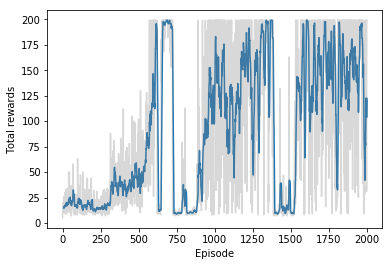

In [23]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'D losses')

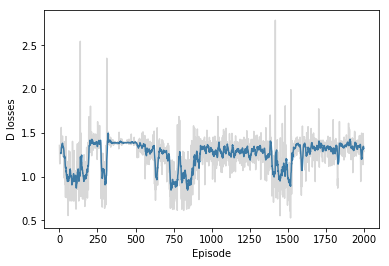

In [24]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'G losses')

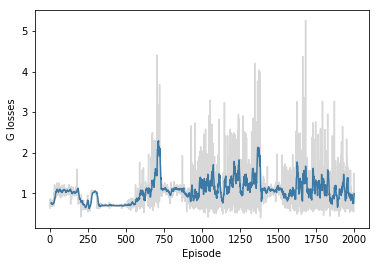

In [25]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'Q losses')

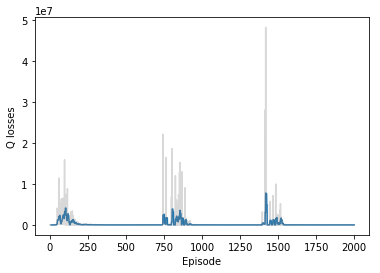

In [26]:
eps, arr = np.array(q_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Q losses')

## Testing

Let's checkout how our trained agent plays the game.

In [27]:
test_episodes = 10
test_max_steps = 400
env.reset()
with tf.Session() as sess:
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    # Save the trained model 
    saver.restore(sess, 'checkpoints/DQAN-cartpole.ckpt')
    
    # iterations
    for ep in range(test_episodes):
        
        # number of env/rob steps
        t = 0
        while t < test_max_steps:
            env.render() 
            
            # Get action from DQAN
            feed_dict = {model.states: state.reshape((1, *state.shape))}
            actions_logits = sess.run(model.actions_logits, feed_dict)
            action = np.argmax(actions_logits)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
            
            # The task is done or not;
            if done:
                t = test_max_steps
                env.reset()
                
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())
            else:
                state = next_state
                t += 1

INFO:tensorflow:Restoring parameters from checkpoints/DQAN-cartpole.ckpt


In [28]:
env.close()

## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.